In [508]:
import copy
import numpy as np
import pandas as pd
import collections
from sklearn import tree 
from sklearn.tree import _tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [509]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [(name, "<=", threshold)]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [(name, ">", threshold)]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node], node)]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    # samples_count = [p[-1][1] for p in paths]
    # ii = list(np.argsort(samples_count))
    # paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = list()
        
        for p in path[:-1]:
            # if rule != "if ":
            #     rule += " and "
            rule += [p,]
        # rule += " then "
        if class_names is None:
            # print("Here", path[-1])
            response = {'pred': path[-1][0][0][0], 'leaf': path[-1][2]}
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            response = {"class": class_names[l], "proba": {100.0*classes[l]/np.sum(classes)}}
        n_samples = path[-1][1]
        rules += [[rule, response, n_samples],]
        
    return rules

In [510]:
def print_single_rule(rule_list):
    for i in range(len(rule_list)):
        rule_tpl = rule_list[i]
        rule_tpl = [str(s) for s in rule_tpl]
        rule_tpl = '('+ ' '.join(rule_tpl) + ')'
        rule_list[i] = rule_tpl
    rule_str = ' AND '.join(rule_list)
    return rule_str

In [511]:
def print_rules(rules, clf=None, dataset=None, labels=None):
    rules = copy.deepcopy(rules)
    # Get Range of Values
    if 'leaf' in rules[0][1]:
        samples = collections.defaultdict(list)
        dec_paths = clf.decision_path(dataset)

        for d, dec in enumerate(dec_paths):
            for i in range(clf.tree_.node_count):
                if dec.toarray()[0][i] == 1:
                    samples[i].append(labels[d]) 
    # Print Total Rules
    print("Total Rules", len(rules))
    # Print the rules
    for r in rules:
        print("Rules: ", print_single_rule(r[0]))
        print("Prediction: ", r[1])
        print("Based on n-samples: ", r[2])
        if 'leaf' in r[1]:
            print("Range", (min(samples[r[1]['leaf']]), max(samples[r[1]['leaf']])))
        print()

In [512]:
def optimal_intervals(intervals):
    # Initialize the result list
    result = []

    # Initialize the first interval
    current_start, current_end = intervals[0]

    for i in range(1, len(intervals)):
        interval_start, interval_end = intervals[i]

        if interval_start <= current_end:
            # Merge intervals if they overlap
            current_end = max(current_end, interval_end)
        else:
            # No overlap, add the current interval to the result
            result.append((current_start, current_end))
            # Move to the next interval
            current_start, current_end = interval_start, interval_end

    # Add the last interval to the result
    result.append((current_start, current_end))

    return result

# Example usage:
intervals = [[1, 3], [2, 5], [6, 8], [7, 10]]
print(optimal_intervals(intervals))  # Output: [[1, 5], [6, 10]]


[(1, 5), (6, 10)]


In [513]:
def merge_intervals(intervals):
    # Step 1: Sort the intervals by their start values
    intervals.sort(key=lambda x: x[0])
    
    # Step 2: Initialize an empty list to store the merged intervals
    merged_intervals = []
    
    for interval in intervals:
        # If the merged_intervals list is empty or if the current interval does not overlap with the previous one
        if not merged_intervals or merged_intervals[-1][1] < interval[0]:
            merged_intervals.append(interval)
        else:
            # There is overlap, so we merge the current and previous intervals
            merged_intervals[-1][1] = max(merged_intervals[-1][1], interval[1])
    
    return merged_intervals

# Example usage:
intervals = [[1, 3], [2, 4], [5, 7], [6, 8]]
merged = merge_intervals(intervals)
print(merged)  # Output: [[1, 4], [5, 8]]


[[1, 4], [5, 8]]


In [514]:
def interval_intersection(intervals):
    if not intervals:
        return None
    
    # Initialize with the first interval
    current_intersection = intervals[0]
    
    for interval in intervals[1:]:
        # Find the intersection of the current_intersection and the next interval
        start = max(current_intersection[0], interval[0])
        end = min(current_intersection[1], interval[1])
        
        # If there is no intersection, return None
        if start > end:
            return None
        
        # Update the current_intersection
        current_intersection = [start, end]
    
    return current_intersection

# Example usage:
intervals = [(1, 5), (2, 6), (3, 7), (4, 8)]
intersection = interval_intersection(intervals)
print(f"The intersection of the intervals is: {intersection}")


The intersection of the intervals is: [4, 5]


In [515]:
def rule_to_interval(rule):
    features = dict()
    for feat, op, val in rule:
        if feat in features:
            if op == '<=':
                features[feat].append([-np.inf, val])
            elif op == '>':
                features[feat].append([val, np.inf])
        else:
            if op == '<=':
                features[feat] = [[-np.inf, val], ]
            elif op == '>':
                features[feat]= [[val, np.inf], ]
    for feat in features:
        # features[feat] = sorted(features[feat])
        # print(feat, features[feat])
        features[feat] = interval_intersection(features[feat])
    return features

In [516]:
from sklearn import datasets

# Load iris dataset
iris = datasets.load_iris()

# Split the data into features and target
dataset = iris['data']
labels = iris['target']

feature_names = iris['feature_names']
class_names = iris['target_names']

In [517]:
 # Create a decision tree classifier object
clf = tree.DecisionTreeClassifier(random_state=42)
 
# Train the decision tree classifier
clf = clf.fit(dataset, labels)

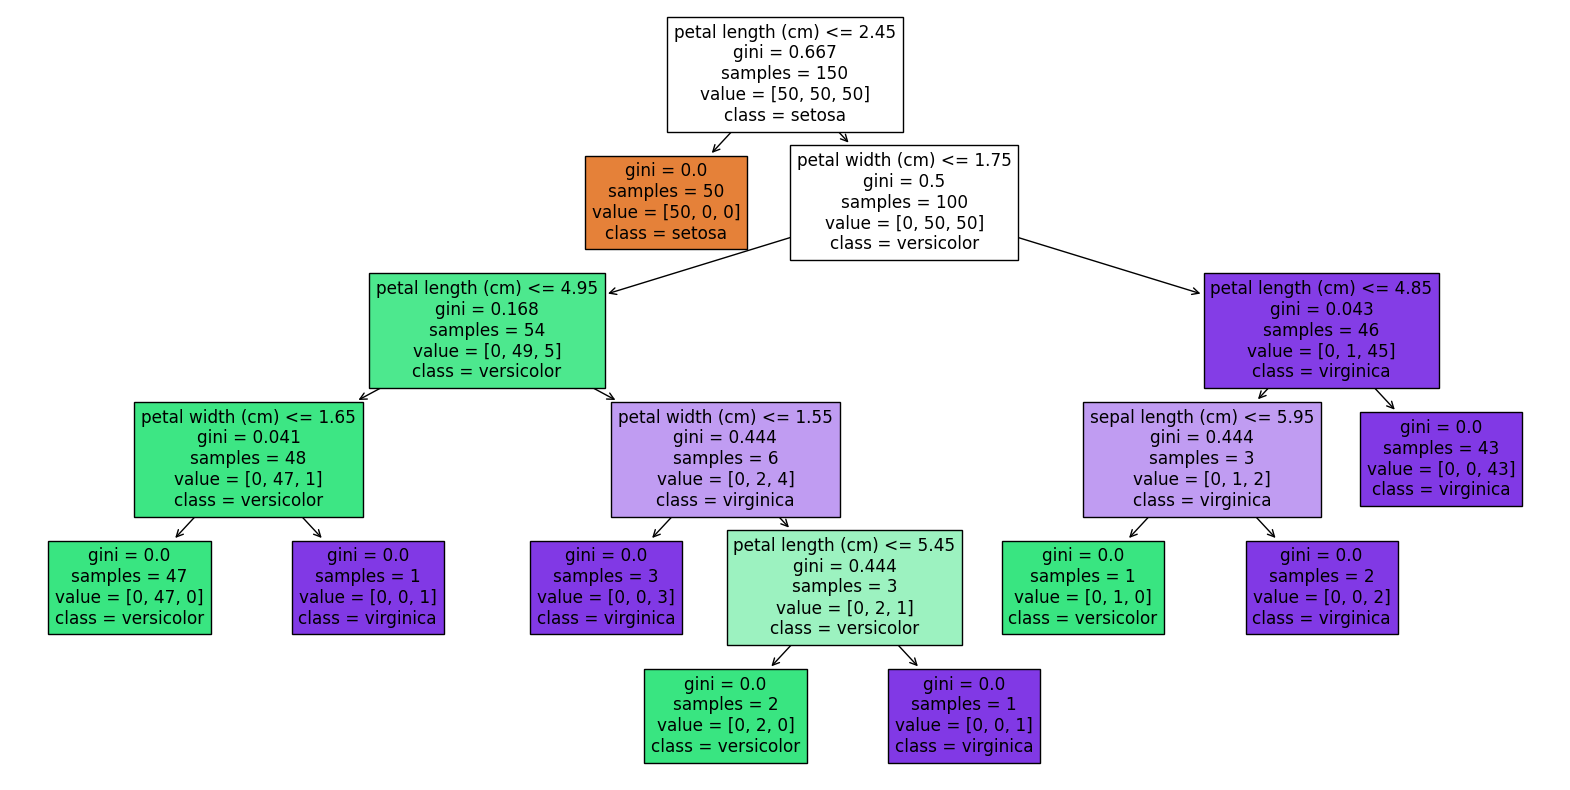

In [518]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))  # Adjust as needed
_ = tree.plot_tree(clf, 
               feature_names=feature_names,  
               class_names=class_names,
               filled=True)
plt.show()

In [519]:
# Visualize the decision tree as text
tree_rules = tree.export_text(clf, feature_names=list(feature_names))
print(tree_rules)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- petal width (cm) <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- petal width (cm) >  1.65
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal length (cm) <= 5.95
|   |   |   |   |--- class: 1
|   |   |   |--- sepal length (cm) >  5.95
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



In [520]:
# Convert the decision tree to human readable rules
rules = get_rules(clf, feature_names, class_names)

# Print the rules
print_rules(rules)


Total Rules 9
Rules:  (petal length (cm) <= 2.449999988079071)
Prediction:  {'class': 'setosa', 'proba': {100.0}}
Based on n-samples:  50

Rules:  (petal length (cm) > 2.449999988079071) AND (petal width (cm) <= 1.75) AND (petal length (cm) <= 4.950000047683716) AND (petal width (cm) <= 1.6500000357627869)
Prediction:  {'class': 'versicolor', 'proba': {100.0}}
Based on n-samples:  47

Rules:  (petal length (cm) > 2.449999988079071) AND (petal width (cm) <= 1.75) AND (petal length (cm) <= 4.950000047683716) AND (petal width (cm) > 1.6500000357627869)
Prediction:  {'class': 'virginica', 'proba': {100.0}}
Based on n-samples:  1

Rules:  (petal length (cm) > 2.449999988079071) AND (petal width (cm) <= 1.75) AND (petal length (cm) > 4.950000047683716) AND (petal width (cm) <= 1.550000011920929)
Prediction:  {'class': 'virginica', 'proba': {100.0}}
Based on n-samples:  3

Rules:  (petal length (cm) > 2.449999988079071) AND (petal width (cm) <= 1.75) AND (petal length (cm) > 4.950000047683716

In [521]:
for rule in rules:
    rule[0] = list(rule_to_interval(rule[0]).items())

In [522]:
rules

[[[('petal length (cm)', [-inf, 2.449999988079071])],
  {'class': 'setosa', 'proba': {100.0}},
  50],
 [[('petal length (cm)', [2.449999988079071, 4.950000047683716]),
   ('petal width (cm)', [-inf, 1.6500000357627869])],
  {'class': 'versicolor', 'proba': {100.0}},
  47],
 [[('petal length (cm)', [2.449999988079071, 4.950000047683716]),
   ('petal width (cm)', [1.6500000357627869, 1.75])],
  {'class': 'virginica', 'proba': {100.0}},
  1],
 [[('petal length (cm)', [4.950000047683716, inf]),
   ('petal width (cm)', [-inf, 1.550000011920929])],
  {'class': 'virginica', 'proba': {100.0}},
  3],
 [[('petal length (cm)', [4.950000047683716, 5.450000047683716]),
   ('petal width (cm)', [1.550000011920929, 1.75])],
  {'class': 'versicolor', 'proba': {100.0}},
  2],
 [[('petal length (cm)', [5.450000047683716, inf]),
   ('petal width (cm)', [1.550000011920929, 1.75])],
  {'class': 'virginica', 'proba': {100.0}},
  1],
 [[('petal length (cm)', [2.449999988079071, 4.8500001430511475]),
   ('peta

In [523]:
from sklearn import datasets

# Load iris dataset
diabetes = datasets.load_diabetes()

# Split the data into features and target
dataset = diabetes['data']
labels = diabetes['target']

feature_names = diabetes['feature_names']
# class_names = diabetes['target_names']

In [524]:
 # Create a decision tree classifier object
clf = tree.DecisionTreeRegressor(max_depth=len(feature_names) * 2,random_state=42)
 
# Train the decision tree classifier
clf = clf.fit(dataset, labels)

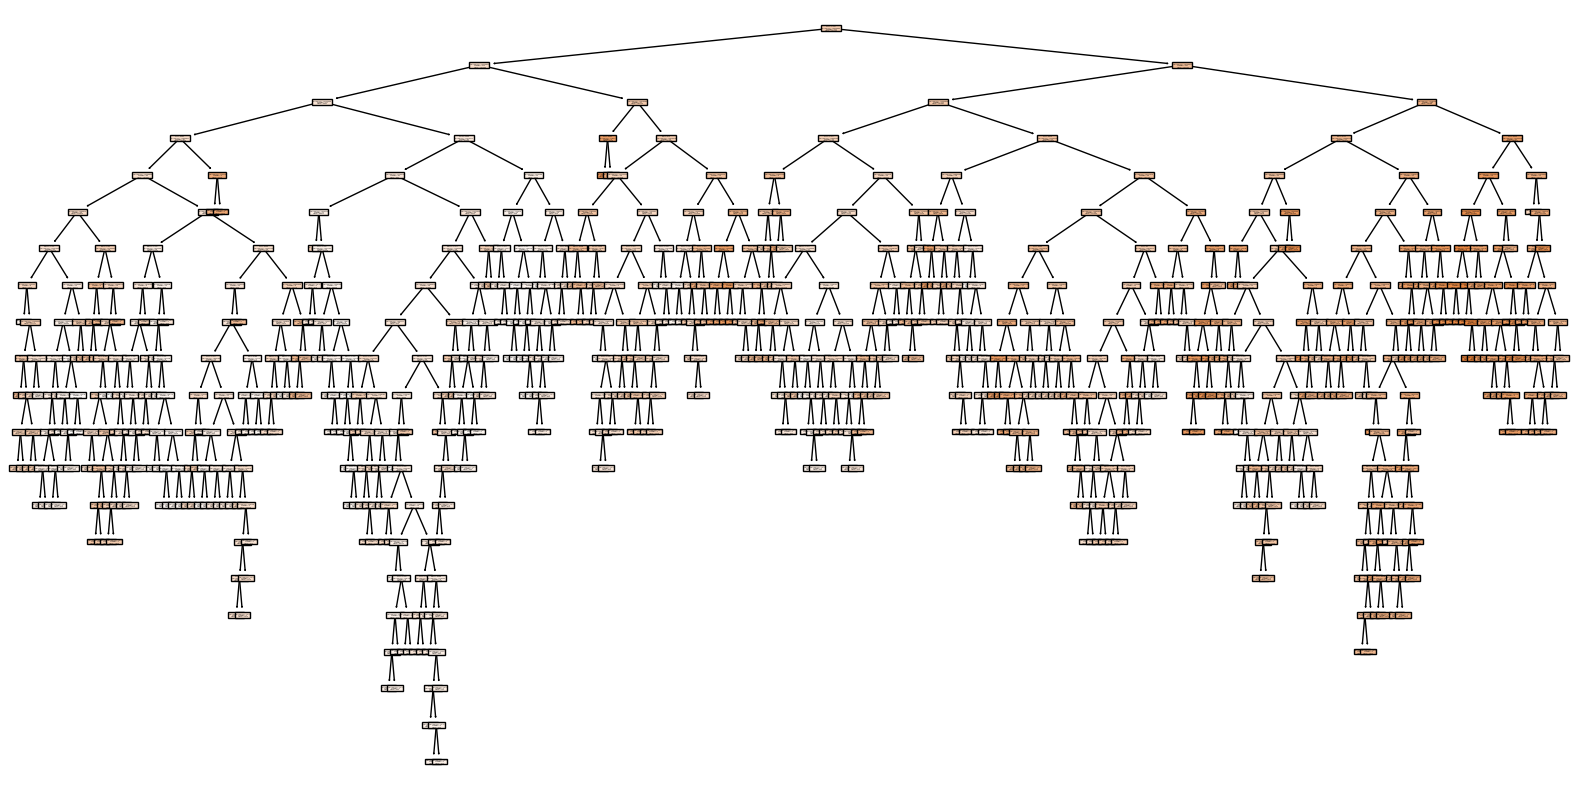

In [525]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))  # Adjust as needed
_ = tree.plot_tree(clf, 
               feature_names=feature_names,  
               filled=True)
plt.show()

In [526]:
# Visualize the decision tree as text
tree_rules = tree.export_text(clf, feature_names=list(feature_names))
print(tree_rules)

|--- s5 <= -0.00
|   |--- bmi <= 0.01
|   |   |--- s3 <= 0.02
|   |   |   |--- s2 <= 0.09
|   |   |   |   |--- sex <= 0.00
|   |   |   |   |   |--- bp <= -0.03
|   |   |   |   |   |   |--- age <= -0.05
|   |   |   |   |   |   |   |--- bp <= -0.09
|   |   |   |   |   |   |   |   |--- value: [55.00]
|   |   |   |   |   |   |   |--- bp >  -0.09
|   |   |   |   |   |   |   |   |--- bp <= -0.05
|   |   |   |   |   |   |   |   |   |--- bp <= -0.07
|   |   |   |   |   |   |   |   |   |   |--- value: [200.00]
|   |   |   |   |   |   |   |   |   |--- bp >  -0.07
|   |   |   |   |   |   |   |   |   |   |--- s1 <= -0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- s1 >  -0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |--- bp >  -0.05
|   |   |   |   |   |   |   |   |   |--- s1 <= -0.04
|   |   |   |   |   |   |   |   |   |   |--- value: [134.00]
|   |   |

In [527]:
# Convert the decision tree to human readable rules
rules = get_rules(clf, feature_names, None)

# Print the rules
print_rules(rules, clf, dataset, labels)

Total Rules 433
Rules:  (s5 <= -0.0037617861526086926) AND (bmi <= 0.0061888848431408405) AND (s3 <= 0.021027816459536552) AND (s2 <= 0.09106491878628731) AND (sex <= 0.003019241616129875) AND (bp <= -0.034935010597109795) AND (age <= -0.05092128552496433) AND (bp <= -0.0917423777282238)
Prediction:  {'pred': 55.0, 'leaf': 8}
Based on n-samples:  1
Range (55.0, 55.0)

Rules:  (s5 <= -0.0037617861526086926) AND (bmi <= 0.0061888848431408405) AND (s3 <= 0.021027816459536552) AND (s2 <= 0.09106491878628731) AND (sex <= 0.003019241616129875) AND (bp <= -0.034935010597109795) AND (age <= -0.05092128552496433) AND (bp > -0.0917423777282238) AND (bp <= -0.05042792856693268) AND (bp <= -0.07108515501022339)
Prediction:  {'pred': 200.0, 'leaf': 11}
Based on n-samples:  1
Range (200.0, 200.0)

Rules:  (s5 <= -0.0037617861526086926) AND (bmi <= 0.0061888848431408405) AND (s3 <= 0.021027816459536552) AND (s2 <= 0.09106491878628731) AND (sex <= 0.003019241616129875) AND (bp <= -0.034935010597109795

In [528]:
for rule in rules:
    rule[0] = list(rule_to_interval(rule[0]).items())

In [529]:
rules

[[[('s5', [-inf, -0.0037617861526086926]),
   ('bmi', [-inf, 0.0061888848431408405]),
   ('s3', [-inf, 0.021027816459536552]),
   ('s2', [-inf, 0.09106491878628731]),
   ('sex', [-inf, 0.003019241616129875]),
   ('bp', [-inf, -0.0917423777282238]),
   ('age', [-inf, -0.05092128552496433])],
  {'pred': 55.0, 'leaf': 8},
  1],
 [[('s5', [-inf, -0.0037617861526086926]),
   ('bmi', [-inf, 0.0061888848431408405]),
   ('s3', [-inf, 0.021027816459536552]),
   ('s2', [-inf, 0.09106491878628731]),
   ('sex', [-inf, 0.003019241616129875]),
   ('bp', [-0.0917423777282238, -0.07108515501022339]),
   ('age', [-inf, -0.05092128552496433])],
  {'pred': 200.0, 'leaf': 11},
  1],
 [[('s5', [-inf, -0.0037617861526086926]),
   ('bmi', [-inf, 0.0061888848431408405]),
   ('s3', [-inf, 0.021027816459536552]),
   ('s2', [-inf, 0.09106491878628731]),
   ('sex', [-inf, 0.003019241616129875]),
   ('bp', [-0.07108515501022339, -0.060756539925932884]),
   ('age', [-inf, -0.05092128552496433]),
   ('s1', [-inf, -0